# Weekly reversal

_UNDER CONSTRUCTION_


- Contrarian trading (Lo and Mackinlay 1990, and others), mean reversion
- implementation shortfall
- structural break with unknown changepoint

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from tqdm import tqdm
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.database import SQL, RedisDB
from finds.busday import BusDay
from finds.structured import CRSP, Benchmarks
from finds.backtesting import fractiles
from finds.econs import lm
from finds.misc import PyR, row_formatted, Show
from secret import credentials, paths, CRSP_DATE
show = Show(ndigits=4, latex=None)
VERBOSE = 0      # 1
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd)
imgdir = paths['images']

__Construct weekly reversal__

Retrieve weekly returns, standardize scores, and compute returns and i.c.

In [3]:
weekday = 3          # wednesday close-to-close
bd = BusDay(sql, endweek=weekday)   # Generate weekly cal
begweek = 19740102   # increased stocks coverage in CRSP in Jan 1973
middate = 19851231   # increased stocks traded in CRSP around this date
endweek = bd.endwk(CRSP_DATE, -1)
rebaldates = bd.date_range(begweek, endweek, freq='weekly')
retdates = bd.date_tuples(rebaldates)
june_universe = 0  # to track when reached a June end to update universe
year = 0           # to track new year to retrieve prices in batch
results = []
lagged_weights = Series(dtype=float) # to track "turnover" of stock weights

Last FamaFrench Date 2023-04-28 00:00:00


Loop over weekly rebalance dates


In [4]:
for rebaldate, pastdates, nextdates in tqdm(zip(rebaldates[1:-1],
                                                retdates[:-1],
                                                retdates[1:])):
    # screen universe each June: largest 5 size deciles
    d = bd.june_universe(rebaldate)
    if d != june_universe:  # need next June's universe
        june_universe = d                        # update universe every June
        univ = crsp.get_universe(june_universe)  # usual CRSP universe screen
        univ = univ[univ['decile'] <= 9]         # drop smallest half stocks

    # retrieve new annual batch of daily prices and returns when start year
    if bd.begyr(rebaldate) != year:
        year = bd.begyr(rebaldate)
        prc = crsp.get_range(dataset='daily',
                             fields=['bidlo', 'askhi', 'prc', 'retx', 'ret'],
                             date_field='date',
                             beg=year,
                             end=bd.offset(bd.endyr(year), 10),
                             cache_mode="rw")

    # get past week's returns, require price at start of week
    past_week = prc[prc.index.get_level_values('date') == rebaldate]['prc']\
        .reset_index()\
        .set_index('permno')\
        .join(crsp.get_ret(*pastdates).reindex(univ.index))\
        .dropna()

    # convert past week's minus returns to standardized weights in portfolio
    weights = ((past_week['ret'].mean() - past_week['ret']) /
               (past_week['ret'].std(ddof=0) * len(past_week)))

    # turnover = total abs change in stock weight, scaled by total abs weight
    chg_weights = pd.concat([weights, -lagged_weights], axis=1)\
                       .fillna(0)\
                       .sum(axis=1)
    total_weight = weights.abs().sum() + lagged_weights.abs().sum()
    lagged_weights = weights
    
    # get next week's returns
    next_week = crsp.get_ret(*nextdates).reindex(past_week.index).fillna(0)

    # get next day's closing prices (or bid-ask quotes), to compute one-day delay cost
    next_day = prc[prc.index.get_level_values('date') ==
                   bd.offset(rebaldate, 1)]\
                   .reset_index()\
                   .set_index('permno')\
                   .drop(columns='date')\
                   .reindex(chg_weights.index)
    avgprc = next_day[['bidlo', 'askhi', 'prc']].abs().mean(axis=1)

    # if no trade next day, then enter position at askhi (long) or bidlo (short)
    bidask = next_day['askhi'].where(weights > 0, next_day['bidlo']).abs()
    avgprc = next_day['prc'].where(next_day['prc'] > 0, bidask)

    # delay slippage (positive is cost) = weights chg * drift of next day price
    drift = avgprc.div(next_day['prc'].abs())\
                  .mul(1 + next_day['ret'])\
                  .sub(1)\
                  .fillna(0)

    # accumulate weekly computations
    results.append(DataFrame({'ret': weights.dot(next_week),
                              'ic': weights.corr(next_week),
                              'n': len(next_week),
                              'beg': nextdates[0],
                              'end': nextdates[1],
                              'absweight': np.sum(weights.abs()),
                              'turnover': chg_weights.abs().sum()/total_weight,
                              'vol': next_week.std(ddof=0),
                              'delay': chg_weights.dot(drift)},
                             index=[rebaldate]))

# Combine accumulated weekly computations
df = pd.concat(results, axis=0)
dates = df.index
df.index = pd.DatetimeIndex(df.index.astype(str))

# Show summary
cols = ['ic' ,'vol', 'ret', 'delay', 'turnover']
indexes = ['Information coefficient', 'Cross-sectional Volatility',
           'Alpha (gross return)', 'Delay cost', 'Portfolio turnover']
show(pd.concat([df[cols].mean(axis=0).rename('mean'),
                df[cols].std(axis=0).rename('std')],
               axis=1).set_index(pd.Index(indexes)),
     caption=f'Summary of Weekly Mean Reversion Strategy {dates[0]}-{dates[-1]}')

2555it [01:13, 34.69it/s]


,mean,std
Summary of Weekly Mean Reversion Strategy 19740109-20221221,,
Information coefficient,0.0398,0.0927
Cross-sectional Volatility,0.0583,0.0203
Alpha (gross return),0.0024,0.0077
Delay cost,0.0019,0.0042
Portfolio turnover,0.7370,0.0384


## Implementation Shortfall

- decision price
- delay
- market impact
- opportunity cost

## Information coefficient

- Grinold rule of thum
- alpha = IC time volatility

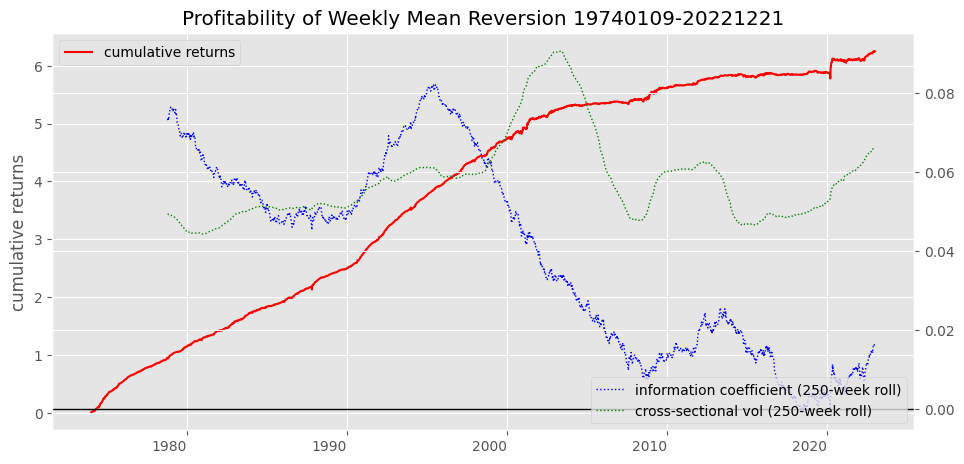

In [5]:
## Plot returns, and rolling avg information coefficient and cross-sectional vol
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
df['ret'].cumsum().plot(ax=ax, ls='-', color='r', rot=0)
ax.legend(['cumulative returns'], loc='upper left')
ax.set_ylabel('cumulative returns')
bx = ax.twinx()
roll = 250  # 250 week rolling average ~ 5 years
df['ic'].rolling(roll).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='b')
df['vol'].rolling(roll).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='g')
#bx.axhline(df['ic'].mean(), linestyle='-', color='C0', lw=2)
bx.axhline(0, linestyle='-', color='black', lw=1)
bx.legend([f"information coefficient ({roll}-week roll)",
           f"cross-sectional vol ({roll}-week roll)"],
          loc='lower right')
ax.set_title(f'Profitability of Weekly Mean Reversion {dates[0]}-{dates[-1]}')
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'weekrev.jpg')

## Structural break with unknown changepoint

- Welch/Chow test
- Andrews

In [6]:
# Structural Break Test with Unknown Changepoint
importr('strucchange')   # R package to use

# Set up data and formulas for R
Y = df['ret']
formula = ro.Formula('y ~ 1')
formula.environment['y'] = PyR(Y.values).ro

# Call R strucchange routines to compute breakpoint statistics
fstats_r = ro.r['Fstats'](formula, **{'from': 1})    # Fstats at every break
breakpoints_r = ro.r['breakpoints'](formula)         # candidate breakpoints
confint_r = ro.r['confint'](breakpoints_r, breaks=1) # conf interval for 1 break
sctest_r = ro.r['sctest'](fstats_r, **{'type': 'aveF'})

# Extract output from R results
confint = PyR(confint_r[0]).frame.iloc[0].astype(int) - 1  # R index starts at 1
output = dict(zip(confint.index, df.index[confint]))       # confidence interval
for k,v in zip(sctest_r.slots['names'][:3], sctest_r[:3]): # significance values
    output[k] = PyR(v).values[0]
output['mean(pre)'] = Y[df.index <= output['breakpoints']].mean() 
output['mean(post)'] = Y[df.index > output['breakpoints']].mean()
fstat = [0] + list(PyR(fstats_r[0]).values) + [0, 0]  # pad beyond from and to 

show(DataFrame(output, index=['sctest']),
     caption="Structural break test with unknown changepoint")

,2.5 %,breakpoints,97.5 %,statistic,p.value,method,mean(pre),mean(post)
Structural break test with unknown changepoint,,,,,,,,
sctest,1998-07-01,2001-07-03,2002-07-31,23.1675,0.0,aveF test,0.0035,0.001


Plot breakpoint F-stats


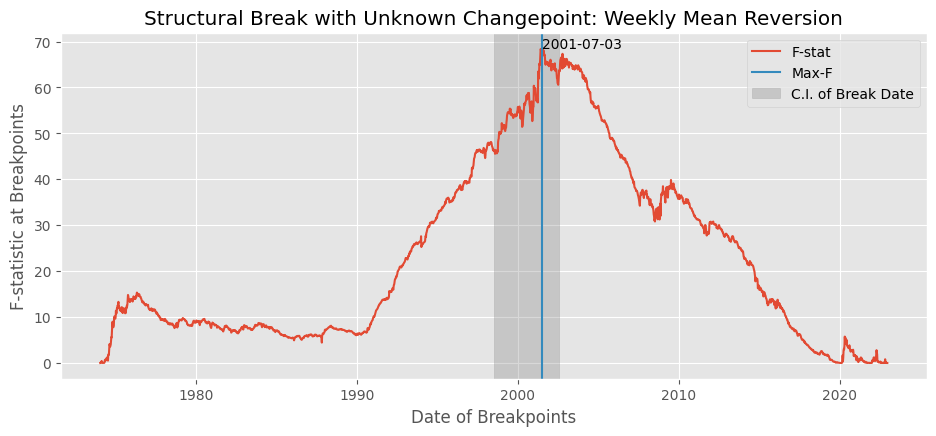

In [7]:
fig, ax = plt.subplots(num=2, clear=True, figsize=(10, 5))
ax.plot(df.index, fstat, color='C0')
arg = np.nanargmax(fstat)
ax.axvline(df.index[arg], color='C1')
ax.axvspan(df.index[confint[0]], df.index[confint[2]], alpha=0.3, color='grey')
ax.legend(['F-stat', 'Max-F', 'C.I. of Break Date'])
ax.annotate(df.index[arg].strftime('%Y-%m-%d'), xy=(df.index[arg], fstat[arg]))
ax.set_ylabel('F-statistic at Breakpoints')
ax.set_xlabel('Date of Breakpoints')
ax.set_title('Structural Break with Unknown Changepoint: '
             'Weekly Mean Reversion')
plt.tight_layout(pad=3)
plt.savefig(imgdir / 'break.jpg')

Compute gross annualized sharpe ratio and delay slippage


In [8]:
market = bench.get_series(permnos=['Mkt-RF'], field='ret').reset_index()
breakpoint = BusDay.to_date(output['breakpoints'])
out = dict()
for select, period in zip([dates > 0, dates <= breakpoint, dates > breakpoint],
                          ['Full', 'Pre-break', 'Post-break']):
    res = df[select].copy()
    res.index = dates[select]

    # align market returns and compute market regression beta
    #res['date'] = res.index
    res['mkt'] = [(1 + market[market['date'].between(*dt)]['Mkt-RF']).prod() - 1
                  for dt in res[['beg','end']].itertuples(index=False)]
    model = lm(res['mkt'], res['ret'], flatten=True)
    
    # save df summary
    out[f"{period} Period"] = {
        'start date': min(res.index),
        'end date': max(res.index),
        'Sharpe Ratio': np.sqrt(52)*res['ret'].mean()/res['ret'].std(),
        'Average Return': res['ret'].mean(),
        'Std Dev Return': res['ret'].std(),
        'Market Beta': model.coefficients[1],
        'Jensen Alpha (annualized)': model.coefficients[0] * 52,
#        'Appraisal Ratio': np.sqrt(52) * model.coefficients[0] / model.stderr,
        'Information Coefficient': res['ic'].mean(),
        'Cross-sectional Vol': res['vol'].mean(),
        'Delay cost': res['delay'].mean(),
        'Turnover Fraction': res['turnover'].mean(),
        #'Abs Weight': res['absweight'].mean(),
        'Num Stocks': int(res['n'].mean()),
    }

# Display as formatted DataFrame
formats = dict.fromkeys(['start date' ,'end date', 'Num Stocks'], '{:.0f}')
show(row_formatted(DataFrame(out), formats=formats, default='{:.4f}'),
     caption="Subperiod Performance of Weekly Mean Reversion Strategy")

(get_series many) SELECT date, permno, ret   FROM benchmarks  WHERE date >= 19000000 AND date <= 29001231     AND permno IN ('Mkt-RF')


,Full Period,Pre-break Period,Post-break Period
Subperiod Performance of Weekly Mean Reversion Strategy,,,
start date,19740109,19740109,20010711
end date,20221221,20010703,20221221
Sharpe Ratio,2.2938,4.2094,0.8167
Average Return,0.0024,0.0035,0.0010
Std Dev Return,0.0077,0.0061,0.0092
Market Beta,0.0928,0.0688,0.1181
Jensen Alpha (annualized),0.1201,0.1792,0.0446
Information Coefficient,0.0398,0.0601,0.0138
Cross-sectional Vol,0.0583,0.0588,0.0578
